# Hierarchical clustering notebook

The hierarchical clustering has 2 approaches. It can be either 'Agglomerative' or 'Divisive'. In aglomerative approach you start with as many clusters as countries and you iteratively merge the most similar clusters into bigger ones. In divisive approach everything is in one big cluster at the beginning and you iteratively exclude from the cluster the countries that are very different from all others and you create clusters out of them.

For our approach aglomerative approach seems like a best option.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scripts import create_dendrogram, apply_hierarchical_clustering
import plotly.express as px

In [2]:
data_pca = pd.read_csv('../data/country-data-pca.csv')
data_raw = pd.read_csv('../data/country-data.csv')

In [3]:
data_pca.head()

,country,PC1,PC2,PC3,PC4
0,Afghanistan,-0.599078,0.095490,0.157554,-0.024333
1,Albania,0.158474,-0.212092,-0.064189,-0.061247
2,Algeria,0.003686,-0.135867,-0.134182,0.133574
3,Angola,-0.650235,0.275975,-0.142672,0.156018
4,Antigua and Barbuda,0.200711,-0.064662,-0.100715,-0.037902


In [4]:
data_raw.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Because hierarchical clustering, like many other algorithms in machine learning, is distance-based (Euclidean distance) we need to rescale the attriutes to the same range

In [5]:
countries = data_pca.country
data_pca.drop(columns=["country"], inplace=True)
columns = data_pca.columns
scaler = StandardScaler()
scaled_data_pca = scaler.fit_transform(data_pca) # numpy array
data_pca = pd.DataFrame(scaled_data_pca, columns=columns)
data_pca.index = countries
data_pca

,PC1,PC2,PC3,PC4
country,,,,
Afghanistan,-1.595658,0.515579,0.887362,-0.153939
Albania,0.422100,-1.145150,-0.361520,-0.387476
Algeria,0.009816,-0.733588,-0.755729,0.845055
Angola,-1.731917,1.490072,-0.803548,0.987046
Antigua and Barbuda,0.534599,-0.349131,-0.567241,-0.239785
...,...,...,...,...
Vanuatu,-0.426373,-0.159953,-0.686609,-0.418176
Venezuela,0.162830,-0.925111,-0.329963,1.565547
Vietnam,0.307670,-0.172960,-1.099632,-1.467697


In [6]:
countries = data_raw.country
data_raw.drop(columns=["country"], inplace=True)
columns = data_raw.columns
scaler = StandardScaler()
scaled_data_raw = scaler.fit_transform(data_raw) # numpy array
data_raw = pd.DataFrame(scaled_data_raw, columns=columns)
data_raw.index = countries
data_raw

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
Albania,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
Algeria,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
Angola,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
Antigua and Barbuda,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817
...,...,...,...,...,...,...,...,...,...
Vanuatu,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754,-0.546913
Venezuela,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678,0.029323
Vietnam,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206,-0.637754


# Dendrograms

## PCA

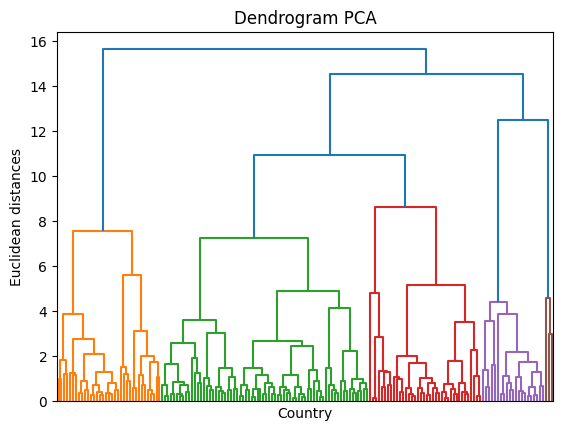

In [7]:
dendrogram = create_dendrogram(data_pca) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram PCA') # title of the dendrogram
plt.xlabel('Country') # label of the x-axis
plt.ylabel('Euclidean distances') # label of the y-axis
plt.xticks([])
plt.show()

## RAW

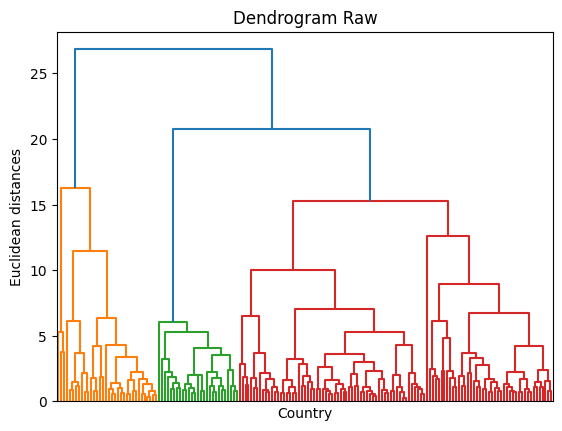

In [8]:
dendrogram = create_dendrogram(data_raw) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram Raw') # title of the dendrogram
plt.xlabel('Country') # label of the x-axis
plt.ylabel('Euclidean distances') # label of the y-axis
plt.xticks([])
plt.show()

Considering the dendrogram above, the optimal number of clusters can be determined as follows; hypothetically, extrapolate all the horizontal lines across the entire dendrogram and then find the longest vertical line that does not cross those hypothetical lines.

Across that longest line, establish a threshold. The number of clusters we can optimally cluster our data equals the count of euclidean distances (vertical lines) the established threshold cuts across.

Knowing the optimal number our data should cluster into; we can now train our clustering model to achieve this goal.

In [9]:
data_pca = apply_hierarchical_clustering(data_pca, 5)

In [10]:
data_raw = apply_hierarchical_clustering(data_raw, 5)
data_raw.to_csv("../data/country-data-with-clusters-test.csv")

In [11]:
#fig = px.scatter(x=data.PC1, y=data.PC2, color=data.cluster, opacity=0.7)
#fig.update_traces(mode="markers", hovertemplate=countries)
#fig.show()

## PCA clusters visualisation

In [12]:
countries = data_pca.index.tolist()
fig = px.scatter_3d(x=data_pca.PC1, y=data_pca.PC2, z=data_pca.PC3, color=data_pca.cluster, opacity=0.7)
fig.update_traces(mode="markers", hovertemplate=countries)
fig.show()

## Raw clusters visualisation on PCA axis values

In [13]:
data_raw["PC1"] = data_pca["PC1"]
data_raw["PC2"] = data_pca["PC2"]
data_raw["PC3"] = data_pca["PC3"]
data_raw["PC4"] = data_pca["PC4"]
countries = data_raw.index.tolist()
fig = px.scatter_3d(x=data_raw.PC1, y=data_raw.PC2, z=data_raw.PC3, color=data_raw.cluster, opacity=0.7)
fig.update_traces(mode="markers", hovertemplate=countries)
fig.show()

## Cluster evaluation

In [14]:
from statistics import mean

def dist(p1: list, p2: list):
    """Calculates the Euclidean distance between two points in n-dimensional space"""
    return np.sqrt(np.sum([(p1[i] - p2[i])**2 for i in range(len(p1))]))


def calculate_centroid(cluster_df: pd.DataFrame) -> list:
    """Return the centroid of a cluster as a list"""
    return cluster_df.describe().loc['mean']


def split_in_clusters(cluster_df: pd.DataFrame) -> list:
    cluster_list = [] # a list to hold each cluster as a DataFrame
    for i in range(len(cluster_df.cluster.unique())):
        cluster_list.append(cluster_df.loc[cluster_df['cluster'] == i])
    return cluster_list


def intra_cluster_variance(cluster_df: pd.DataFrame) -> float:  
    cluster_list = split_in_clusters(cluster_df)
    
    # calculate centroid in each cluster
    cluster_centroids = [calculate_centroid(cluster) for cluster in cluster_list]
    
    # calculate intra variance in each cluster and store in list
    cluster_intra_variance = []
    for (cluster, centroid) in zip(cluster_list, cluster_centroids):
        cluster_intra_variance.append(sum([dist(instance, centroid) for instance in cluster.values.tolist()]))
    
    return cluster_list, cluster_intra_variance




## Cluster intra variance mean for different cluster numbers in range <1,10>

In [15]:
cluster_intra_variance_list = []
for i in range(1, 11, 1):
    data_pca = apply_hierarchical_clustering(data_pca, i)

    cluster_list, cluster_intra_variance = intra_cluster_variance(data_pca)
    cluster_intra_variance_list.append(mean(cluster_intra_variance))
    print(f"Cluster num = {i}, cluster_intra_variance mean = {mean(cluster_intra_variance)}")

Cluster num = 1, cluster_intra_variance mean = 298.6672195432444
Cluster num = 2, cluster_intra_variance mean = 130.39692811673422
Cluster num = 3, cluster_intra_variance mean = 76.32430694197564
Cluster num = 4, cluster_intra_variance mean = 53.84449395488293
Cluster num = 5, cluster_intra_variance mean = 39.51268605222882
Cluster num = 6, cluster_intra_variance mean = 31.149988795892277
Cluster num = 7, cluster_intra_variance mean = 25.393457149920206
Cluster num = 8, cluster_intra_variance mean = 20.78889509651215
Cluster num = 9, cluster_intra_variance mean = 17.770964895929247
Cluster num = 10, cluster_intra_variance mean = 15.223387689518987


## Cluster intra variance mean plotted

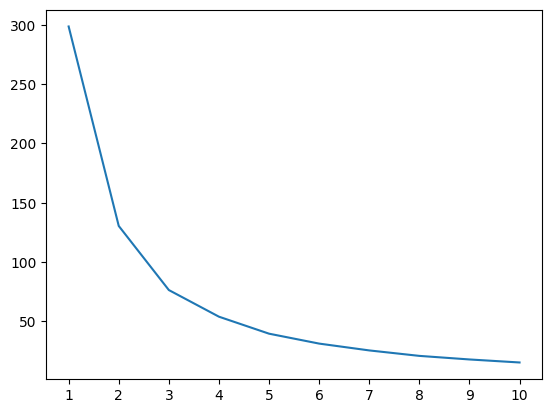

In [16]:
cluster_intra_variance_mean_list = np.array(cluster_intra_variance_list)
plt.plot(cluster_intra_variance_mean_list)
plt.xticks(np.arange(len(cluster_intra_variance_mean_list)), np.arange(1, len(cluster_intra_variance_mean_list)+1))
plt.show()

# Plot country clusters on map

In [17]:
import geopandas
import folium
from datetime import datetime
from scripts import create_map_plot

data_pca = apply_hierarchical_clustering(data_pca, 5)
data_pca["name"] = data_pca.index

create_map_plot(data_pca, "../out/Kamil")